# Only use competicion data for both fine-tuning and final classification

Data used for fine-tuning and final classification :

* corpus completo 5 temas - 08-sep-2016 - codificacion 5 temas.csv (competition)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
from fastai.text import *
import html
import json

import pandas as pd
import numpy as np
from google_drive_downloader import GoogleDriveDownloader as gdd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix

np.random.seed(42)

In [2]:
DATA_PATH=Path('./DATA/2017')
# DATA_PATH=Path('./data/election_tweets')

WIKILM_PATH=Path('./WIKI_LM/LM')
PRE_FINETUNE_PATH=Path('./FINETUNE/2017/')

TWEETSLM_PATH=Path('./TWEETS_LM/2017')
CLAS_PATH=Path('./TWEETS_CLAS/2017')

BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

## Prepare Data

In [3]:
df_trn = pd.read_csv(DATA_PATH/'train.csv', header=None)
df_val = pd.read_csv(DATA_PATH/'validation.csv', header=None)
df_tst = pd.read_csv(DATA_PATH/'test.csv', header=None)
df_gen = pd.read_csv(DATA_PATH/'general.csv', header=None)

In [4]:
tweets = np.concatenate([df_trn, df_val, df_gen])
tweets_tst = np.concatenate([df_tst])
del df_trn, df_val, df_tst, df_gen

tweets[:5]

array([[3,
        '-Me caes muy bien \n-Tienes que jugar más partidas al lol con Russel y conmigo\n-Por qué tan Otako, deja de ser otako\n-Haber si me muero'],
       [0,
        '@myendlesshazza a. que puto mal escribo\n\nb. me sigo surrando help \n\n3. ha quedado raro el "cómetelo" ahí JAJAJAJA'],
       [0,
        '@estherct209 jajajaja la tuya y la d mucha gente seguro!! Pero yo no puedo sin mi melena me muero '],
       [1, 'Quiero mogollón a @AlbaBenito99 pero sobretodo por lo rápido que contesta a los wasaps '],
       [0, 'Vale he visto la tia bebiendose su regla y me hs dado muchs grima ']], dtype=object)

In [5]:
np.random.shuffle(tweets)
tweets[:5]

array([[0,
        'Salimos hacia Madrid porque mañana hay parlamento a primera hora. Por la tarde debate de empleo y mañana rechazo al repago en sanidad.'],
       [1,
        'GRACIAS. Por seguirnos en #cabalgatagtv dsd medio mundo.Amigos d @giraldagtv nos siguieron el pasado viernes desde ¡¡62 países!! #sevillahoy'],
       [3, 'Uff. Ni idea. RT @ValeSanz1: @AlejandroSanz donde fue esta foto? :) http://t.co/dYGkDYMP'],
       [0,
        'Hoy en Sopuerta(Bizkaa):Un edil de Bildu amenaza a sus vecinos por ir contra el proceso -http://t.co/qbrDGMWU vía @larazon_es'],
       [2,
        '@Javiturpeiro eso dice mucho de él... así que nada, tómate tu tiempo que cuando estés preparado, todo llegará ']],
      dtype=object)

In [6]:
# print(df.shape)
# print(df.columns.values)
# print(df['Texto'].isnull().any())
# print(df['Tema_05'].isnull().any())
# print(df['Tema_05'].value_counts())

In [7]:
# encode lables
# df['Tema_05'] = df['Tema_05'].replace([1, 2, 9, 10, 11], [1, 2, 3, 4, 5])
# print(df['Tema_05'].value_counts())

In [8]:
# tweets = df['Texto'].values
# labels = df['Tema_05'].values
# LABELS = set(labels)

In [6]:
def flattern(A):
    'Source: https://stackoverflow.com/a/17867797/7273299'
    
    'Flattens a list of lists and strings into a list.'
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flattern(i))
        else: rt.append(i)
    return rt

def isInt(v):
    'Source: https://stackoverflow.com/a/9859202/7273299'
    
    'Checks if a string is a number.'
    try:     i = int(v)
    except:  return False
    return True

def char_count(word, chars, lbound=2):
    char_count = [word.count(char) for char in chars]
    return all(i >= lbound for i in char_count)

def replace_lol(repl_str, texts):
    for string, chars in repl_str:
        texts = [[[string, i] if char_count(i, set(chars), 2) else i for i in text.split()] for text in texts]
        texts = np.array([flattern(text) for text in texts])
        texts = np.array([' '.join(text) for text in texts])
    return texts

def preprocess_tweets(tweets):
    """
    twitter specific text processing and shuffle
    """
    # Remove \n
    tweets = np.array([str(i).replace('\n','') for i in tweets])
    tweets = np.array([str(i).replace('&lt;','') for i in tweets])
    tweets = np.array([str(i).replace('&gt;','') for i in tweets])
    
    # Placeholders for hyperlinks and user references
    tweets = [['hyp_link' if i.startswith('http') 
               else 'user_ref' if i.startswith('@')
               else 'hash_tag' if i.startswith('#')
               else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([' '.join(i) for i in tweets])

    # Prefix for Hashtags
#     tweets = [[['hash_tag', i] if i.startswith('#') else i for i in tweet.split()] for tweet in tweets]
#     tweets = np.array([flattern(tweet) for tweet in tweets])
#     tweets = np.array([' '.join(i) for i in tweets])

    # Prefix for integers
    tweets = [[['int_string', i] if isInt(i) else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([flattern(tweet) for tweet in tweets])
    tweets = np.array([' '.join(i) for i in tweets])

    # Prefix for slang
    tweets = [[['que', 'slang_string'] if i in ['q', 'k', 'qu', 'ke', 'qe'] 
               else ['por', 'slang_string'] if i=='x' 
               else ['porque', 'slang_string'] if i in ['xq', 'pq', 'porq'] 
               else ['de', 'slang_string'] if i=='d' 
               else ['te', 'slang_string'] if i=='t'
               else ['también', 'slang_string'] if i=='tb'
               else ['Que', 'slang_string'] if i in ['Q', 'K', 'Qu','Ke', 'Qe'] 
               else ['Por', 'slang_string'] if i=='X'
               else ['Porque', 'slang_string'] if i in ['Xq', 'Pq', 'Porq'] 
               else ['De', 'slang_string'] if i=='D' 
               else ['Te', 'slang_string'] if i=='T'
               else ['También', 'slang_string'] if i=='Tb'
               else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([flattern(tweet) for tweet in tweets])
    tweets = np.array([' '.join(i) for i in tweets])

    # Lol type characters
    repl_str = [('risa_ja','ja'), ('risa_ji','ji'), ('risa_je','je'), ('risa_jo','jo'), ('risa_ju', 'ju'),
               ('risa_ja','aj'), ('risa_ji','ij'), ('risa_ju', 'uj')]

    # Adding prefix to lol type characters
    tweets = replace_lol(repl_str, tweets)

   
    
    return tweets



In [7]:
tweets[:,1] = preprocess_tweets(tweets[:,1])
tweets_tst[:,1] = preprocess_tweets(tweets_tst[:,1])

In [8]:
tweets[:5]

array([[0,
        'Salimos hacia Madrid porque mañana hay parlamento a primera hora. Por la tarde debate de empleo y mañana rechazo al repago en sanidad.'],
       [1,
        'GRACIAS. Por seguirnos en hash_tag dsd medio mundo.Amigos de slang_string user_ref nos siguieron el pasado viernes desde ¡¡62 países!! hash_tag'],
       [3, 'Uff. Ni idea. RT user_ref user_ref donde fue esta foto? :) hyp_link'],
       [0,
        'Hoy en Sopuerta(Bizkaa):Un edil de Bildu amenaza a sus vecinos por ir contra el proceso -http://t.co/qbrDGMWU vía user_ref'],
       [2,
        'user_ref eso dice mucho de él... así que nada, tómate tu tiempo que cuando estés preparado, todo llegará']],
      dtype=object)

In [9]:
POSI_train_docs = [tweets[i] for i in range(len(tweets)) if tweets[i, 0] == 0]
NEGA_train_docs = [tweets[i] for i in range(len(tweets)) if tweets[i, 0] == 1]
NEUT_train_docs = [tweets[i] for i in range(len(tweets)) if tweets[i, 0] == 2]
NONE_train_docs = [tweets[i] for i in range(len(tweets)) if tweets[i, 0] == 3]
del tweets

level_train_docs = [POSI_train_docs,NEGA_train_docs,NEUT_train_docs,NONE_train_docs]

fmt = """Positive Sentences = {:d}
       \rNegative Sentences = {:d}
       \rNeutral  Sentences = {:d}
       \rNone Values        = {:d}"""

print(fmt.format(len(POSI_train_docs),
                 len(NEGA_train_docs),
                 len(NEUT_train_docs),
                 len(NONE_train_docs)))

minSentLvl = min(len(POSI_train_docs),len(NEGA_train_docs),len(NEUT_train_docs),len(NONE_train_docs))

print('Minimum number of sentences per level : ', minSentLvl)

import random
tweets_bal = []
for i in range(len(level_train_docs)):
    level_per = random.sample(level_train_docs[i],len(level_train_docs[i]))
    tweets_bal.append(level_per[:minSentLvl])
    
print("New size of sentences:\n")
fmt = """Positive Sentences = {:d}
       \rNegative Sentences = {:d}
       \rNeutral  Sentences = {:d}
       \rNone Values        = {:d}"""

print(fmt.format(len(tweets_bal[0]),
                 len(tweets_bal[1]),
                 len(tweets_bal[2]),
                 len(tweets_bal[3])))

flat_tweets_bal = [item for sublist in tweets_bal for item in sublist]
shuf_tweets_bal = random.sample(flat_tweets_bal,len(flat_tweets_bal))

assert (len(shuf_tweets_bal) == 4 * minSentLvl)
print("shuf_tweets_bal size = ", len(shuf_tweets_bal))

shuf_tweets_bal = np.array(shuf_tweets_bal)
print(shuf_tweets_bal[:5])

Positive Sentences = 2819
Negative Sentences = 3358
Neutral  Sentences = 872
None Values        = 1683
Minimum number of sentences per level :  872
New size of sentences:

Positive Sentences = 872
Negative Sentences = 872
Neutral  Sentences = 872
None Values        = 872
shuf_tweets_bal size =  3488
[[0
  'De modo que slang_string user_ref entra a presidir la Junta de Andalucia tras la marcha de Chaves y todos calladitos...y ahora a freír a Ana Botella...']
 [0 'El Supremo condena a Garzón y lo inhabilita por el caso de las escuchas de la Gürtel.']
 [1 'user_ref me quedo con la tónic ya sabes que soy un clásico']
 [1
  'Empieza el acto de homenaje a la Constitución con el próximo Presidente del Gobierno. hash_tag hyp_link']
 [3
  'Belloc, por otra parte grande, dijo que Wells era un provinciano y este respondió: "Al parecer, el señor Belloc ha nacido en toda Europa".']]


In [9]:
col_names = ['label', 'tweet']

In [10]:
tweets_train, tweets_valid, labels_train, labels_valid = train_test_split(
                                                    tweets[:,1], tweets[:,0],
                                                    stratify=tweets[:,0], 
                                                    test_size=0.10)

# tweets_train, tweets_valid, labels_train, labels_valid = train_test_split(
#                                                     shuf_tweets_bal[:,1], shuf_tweets_bal[:,0],
#                                                     stratify=shuf_tweets_bal[:,0], 
#                                                     test_size=0.10)

print('train shapes:', tweets_train.shape, labels_train.shape)
print('valid shapes:', tweets_valid.shape, labels_valid.shape)
print('test shapes:', tweets_tst.shape)

train shapes: (7858,) (7858,)
valid shapes: (874,) (874,)
test shapes: (1899, 2)


In [11]:
df_trn = pd.DataFrame({'tweet':tweets_train, 'label':labels_train}, columns=col_names)
df_val = pd.DataFrame({'tweet':tweets_valid, 'label':labels_valid}, columns=col_names)
df_tst = pd.DataFrame({'tweet':tweets_tst[:,1], 'label':tweets_tst[:,0]}, columns=col_names)

In [12]:
print(df_trn['label'].value_counts())
print(df_val['label'].value_counts())
print(df_tst['label'].value_counts())

1    3022
0    2537
3    1514
2     785
Name: label, dtype: int64
1    336
0    282
3    169
2     87
Name: label, dtype: int64
Series([], Name: label, dtype: int64)


In [13]:
def balance_df(df):
    lst = [df]
    max_size = df['label'].value_counts().max()
    for class_index, group in df.groupby('label'):
        lst.append(group.sample(max_size-len(group), replace=True))
    df = pd.concat(lst)
    return df

df_trn = balance_df(df_trn)

print(df_trn['label'].value_counts())
print(df_val['label'].value_counts())
print(df_tst['label'].value_counts())

3    3022
2    3022
1    3022
0    3022
Name: label, dtype: int64
1    336
0    282
3    169
2     87
Name: label, dtype: int64
Series([], Name: label, dtype: int64)


In [14]:
df_trn.to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'validation.csv', header=False, index=False)
df_tst.to_csv(CLAS_PATH/'test.csv', header=False, index=False)
df_trn.shape, df_val.shape
# (CLAS_PATH/'classes.txt').open('w').writelines(f'{o}\n' for o in LABELS)

((12088, 2), (874, 2))

### Create dataframes for Language Model fine-tuning

In [15]:
tweets_lm = np.concatenate([tweets_train, tweets_valid, tweets_tst[:,1]])
labels_lm = np.concatenate([labels_train, labels_valid, [0]*len(tweets_tst[:,0])])

tweets_train_lm, tweets_valid_lm, labels_train_lm, labels_valid_lm = train_test_split(
                                                    tweets_lm, labels_lm,
                                                    stratify=labels_lm, 
                                                    test_size=0.10)

In [16]:
df_trn = pd.DataFrame({'tweet':tweets_train_lm, 'label':[0]*len(tweets_train_lm)}, columns=col_names)
df_val = pd.DataFrame({'tweet':tweets_valid_lm, 'label':[0]*len(tweets_valid_lm)}, columns=col_names)

In [17]:
df_trn.to_csv(TWEETSLM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(TWEETSLM_PATH/'validation.csv', header=False, index=False)

In [18]:
df_trn.shape, df_val.shape

((9567, 2), (1064, 2))

## Tokenize and Standarize General Tokens


In [19]:
chunksize=24000

re1 = re.compile(r'  +')

In [20]:
def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer(lang='es').proc_all_mp(partition_by_cores(texts), lang='es')
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
#     print(df)
    for i, r in enumerate(df):
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [21]:
df_trn = pd.read_csv(TWEETSLM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(TWEETSLM_PATH/'validation.csv', header=None, chunksize=chunksize)

In [22]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

In [23]:
len(tok_trn),len(trn_labels), len(tok_val), len(val_labels)

(9567, 9567, 1064, 1064)

In [24]:
print(tok_trn[:2])

[['\n', 'xbos', 'curioso', '.', 'al', 'de', 'amaiur', 'no', 'le', 'han', 'aplaudido', 'ni', 'los', 'suyos'], ['\n', 'xbos', 'portada', 't_up', 'abc', 'hyp_link', '...']]


In [25]:
(TWEETSLM_PATH/'tmp').mkdir(exist_ok=True)

In [26]:
np.save(TWEETSLM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(TWEETSLM_PATH/'tmp'/'tok_val.npy', tok_val)

In [27]:
tok_trn = np.load(TWEETSLM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(TWEETSLM_PATH/'tmp'/'tok_val.npy')

In [28]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(20)

[('\n', 9567),
 ('xbos', 9567),
 ('de', 6911),
 ('user_ref', 5641),
 ('.', 4977),
 (',', 4447),
 ('que', 4361),
 ('la', 4278),
 ('el', 3901),
 ('en', 3560),
 ('a', 3548),
 ('y', 3402),
 ('!', 2863),
 ('hyp_link', 2400),
 ('no', 2125),
 ('hash_tag', 1771),
 ('"', 1735),
 ('t_up', 1682),
 ('es', 1608),
 ('los', 1602)]

In [29]:
max_vocab = 60000
min_freq = 1

In [30]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

7960

In [31]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [32]:
np.save(TWEETSLM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(TWEETSLM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(TWEETSLM_PATH/'tmp'/'itos.pkl', 'wb'))

## Load Encoder Weights for Language Model

In [33]:
BACKBONE_MODEL = PRE_FINETUNE_PATH/'models/lm1_wgts.h5'

In [34]:
wgts = torch.load(BACKBONE_MODEL, map_location=lambda storage, loc: storage)

We calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target IMDB LM.

In [35]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [36]:
itos2 = pickle.load((PRE_FINETUNE_PATH/'tmp'/'itos.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

Before we try to transfer the knowledge from wikitext to the IMDB LM, we match up the vocab words and their indexes. We use the defaultdict container once again, to assign mean weights to unknown IMDB tokens that do not exist in wikitext103.

In [37]:
em_sz,nh,nl = 400,1150,3

In [38]:
trn_lm = np.load(TWEETSLM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(TWEETSLM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(TWEETSLM_PATH/'tmp'/'itos.pkl', 'rb'))

In [39]:
vs=len(itos)
vs,len(trn_lm)

(7960, 9567)

In [40]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
n_replaced_vocab = 0

for i,w in enumerate(itos):
    r = stoi2[w]
    if r>=0 :
        new_w[i] = enc_wgts[r]
        n_replaced_vocab +=1
    else:
        new_w[i] = row_m

print(f'Reuse {n_replaced_vocab} word embeddings from fine-tuning')
print(f'{vs-n_replaced_vocab} where not in vocab from fine-tuning')

Reuse 6653 word embeddings from fine-tuning
1307 where not in vocab from fine-tuning


"We now overwrite the weights into the wgts odict. The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying."

In [41]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

## Language Model Finetuning

In [42]:
wd=1e-7
bptt=70
bs=32
em_sz,nh,nl = 400,1150,3
opt_fn = partial(optim.SGD, momentum=0.9)

In [43]:
trn_lm = np.load(TWEETSLM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(TWEETSLM_PATH/'tmp'/'val_ids.npy')
trn_lm = np.concatenate(trn_lm)
val_lm = np.concatenate(val_lm)

In [44]:
itos = pickle.load(open(TWEETSLM_PATH/'tmp'/'itos.pkl', 'rb'))
vs = len(itos)

trn_dl = LanguageModelLoader(trn_lm, bs, bptt)
val_dl = LanguageModelLoader(val_lm, bs, bptt)
md = LanguageModelData(TWEETSLM_PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [45]:
#drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])

In [46]:
learn = md.get_model(opt_fn, em_sz, nh, nl, dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learn.metrics = [accuracy]
learn.unfreeze()

In [47]:
learn.model.load_state_dict(wgts)

In [48]:
learn.lr_find2(start_lr=1e-1,end_lr=6e-1, num_it=300)

 45%|████▍     | 39/87 [00:15<00:18,  2.60it/s, loss=4.1]

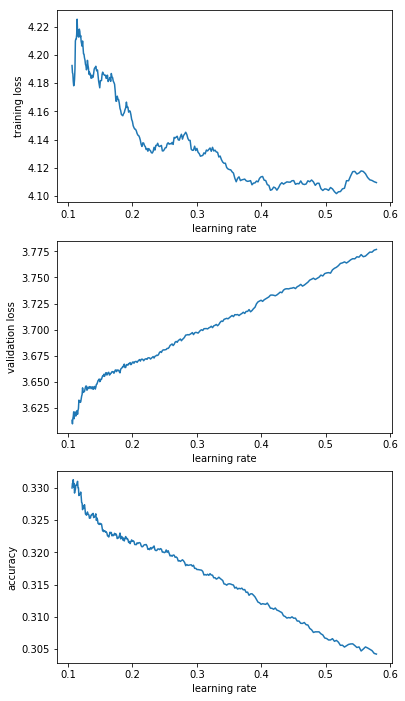

In [49]:
learn.sched.plot()

In [50]:
lr= 11e-2
lrs = lr

In [51]:
learn.clip=0.12

In [52]:
learn.fit(lr, 20, cycle_len=1, use_clr_beta=(10,33,0.95,0.85), best_save_name='lm1_wgts')

epoch      trn_loss   val_loss   accuracy   
    0      4.109401   3.530917   0.34115   
    1      4.091661   3.533953   0.340954  
    2      4.077289   3.531579   0.341213  
    3      4.076585   3.549488   0.339013  
    4      4.058942   3.551182   0.339185  
    5      4.055554   3.544927   0.339388  
    6      4.048155   3.551842   0.338837  
    7      4.046229   3.546146   0.337728  
    8      4.037368   3.540209   0.33987   
    9      4.037035   3.545062   0.337951  
    10     4.03795    3.546409   0.338497  
    11     4.033521   3.547641   0.337734  
    12     4.037594   3.562937   0.336285  
    13     4.026504   3.556677   0.336304  
    14     4.025261   3.554037   0.336252  
    15     4.017627   3.552491   0.336966  
    16     4.019788   3.551053   0.337717  
    17     4.012328   3.565929   0.336268  
    18     3.999311   3.566153   0.336169  
    19     3.996494   3.550196   0.336873  


[array([3.5502]), 0.33687298125240794]

In [53]:
learn.load('lm1_wgts')
learn.save_encoder('lm1_enc')

## Classifier tokens

In [54]:
chunksize=24000

re1 = re.compile(r'  +')

In [55]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'validation.csv', header=None, chunksize=chunksize)
df_tst = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)

In [56]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)
tok_tst, tst_labels = get_all(df_tst, 1)

In [57]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

In [58]:
np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)
np.save(CLAS_PATH/'tmp'/'tok_tst.npy', tok_tst)

In [59]:
np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)
# np.save(CLAS_PATH/'tmp'/'tst_labels.npy', tst_labels)

# df = pd.read_csv(CLAS_PATH/'test_labels.csv')
# df['label']=df['label'].replace(['N','P','NEU','NONE'],[0,1,2,3])
# np.save(CLAS_PATH/'tmp'/'tst_labels.npy', df['label'].values)

In [60]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')
tok_tst = np.load(CLAS_PATH/'tmp'/'tok_tst.npy')

In [61]:
itos = pickle.load((TWEETSLM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

7960

In [62]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])
tst_clas = np.array([[stoi[o] for o in p] for p in tok_tst])

In [63]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)
np.save(CLAS_PATH/'tmp'/'tst_ids.npy', tst_clas)

## Classifier

In [64]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [65]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [66]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 96

In [67]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1
print(c)

4


In the classifier, unlike LM, we need to read a tweet at a time. We do not deal with equal bptt size batches, so we have to pad the sequences to the same length in each batch. To create batches of similar sized movie tweets, we use a sortish sampler method invented by [@Smerity](https://twitter.com/Smerity) and [@jekbradbury](https://twitter.com/jekbradbury)

The sortishSampler cuts down the overall number of padding tokens the classifier ends up seeing.

In [68]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(TWEETSLM_PATH, trn_dl, val_dl, test_dl=val_dl)

In [69]:
#dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.8
dps = np.array([0.4,0.5,0.05,0.3,0.4])

In [70]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [71]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [72]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.12
learn.metrics = [accuracy]

In [73]:
# wd = 1e-7
learn.load_encoder('lm1_enc')

In [74]:
learn.freeze_to(-1)

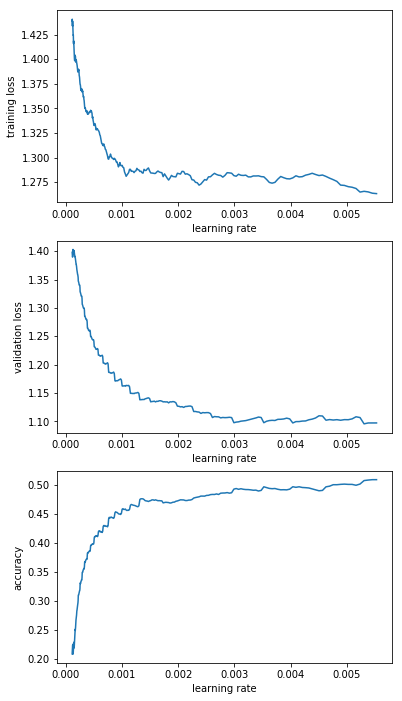

In [75]:
learn.lr_find2(start_lr=1e-4,end_lr=6e-3, num_it=300)
learn.sched.plot()

In [76]:
lr= 15e-4
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [77]:
learn.fit(lrs, 5, wds=wd, cycle_len=1, use_clr_beta=(32,10,0.8,0.7), best_save_name='clas2_0')

epoch      trn_loss   val_loss   accuracy   
    0      1.242992   1.112472   0.49814   
    1      1.235277   1.101691   0.515495  
    2      1.217098   1.099616   0.53112   
    3      1.21605    1.080169   0.535054  
    4      1.206814   1.085353   0.51675   


[array([1.08535]), 0.516750375607184]

In [78]:
learn.load('clas2_0')

In [79]:
learn.freeze_to(-2)

In [80]:
learn.fit(lrs, 10, wds=wd, cycle_len=1, use_clr_beta=(32,10,0.8,0.7),  best_save_name='clas2_1')

epoch      trn_loss   val_loss   accuracy   
    0      1.201922   1.087328   0.517941  
    1      1.184248   1.052046   0.553571  
    2      1.173399   1.049531   0.530227  
    3      1.151445   1.04026    0.532617  
    4      1.141734   1.046126   0.547126  
    5      1.116176   1.04195    0.547898  
    6      1.110379   1.045627   0.522786  
    7      1.116311   1.014008   0.569057  
    8      1.074728   1.034134   0.539528  
    9      1.078903   1.024468   0.552827  


[array([1.02447]), 0.5528273905760476]

In [81]:
learn.load('clas2_1')

In [82]:
learn.unfreeze()

In [83]:
learn.fit(lr, 20, cycle_len=1, use_clr_beta=(32,10,0.8,0.7), best_save_name='final')

epoch      trn_loss   val_loss   accuracy   
    0      1.090749   1.036817   0.571708  
    1      0.989611   1.00565    0.575446  
    2      0.880519   0.983893   0.594652  
    3      0.777733   1.017043   0.61316   
    4      0.680783   1.095591   0.604929  
    5      0.563901   1.110266   0.62181   
    6      0.525873   1.193474   0.599535  
    7      0.446141   1.172076   0.620833  
    8      0.414768   1.274773   0.602623  
    9      0.377282   1.326725   0.613644  
    10     0.321534   1.398535   0.60718   
    11     0.343653   1.454433   0.604669  
    12     0.301423   1.524502   0.618592  
    13     0.260408   1.644125   0.602065  
    14     0.219023   1.582872   0.615179  
    15     0.211874   1.605049   0.592346  
    16     0.234828   1.618709   0.599507  
    17     0.205338   1.740966   0.60732   
    18     0.188618   1.838999   0.608017  
    19     0.195175   1.735054   0.609645  


[array([1.73505]), 0.6096447223265257]

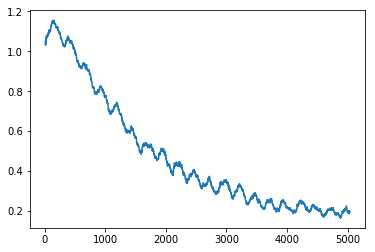

In [84]:
learn.load('final')
learn.sched.plot_loss()

## Model Evaluation

In [85]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [86]:
bs = 256
bptt,em_sz,nh,nl = 70,400,1150,3

tst_sent = np.load(CLAS_PATH/'tmp/tst_ids.npy')
tst_lbls = np.load(CLAS_PATH/'tmp/tst_labels.npy').flatten()
# tst_lbls -= tst_lbls.min()
c=4 #int(tst_lbls.max())+1
tst_ds = TextDataset(tst_sent, tst_lbls)
tst_samp = SortSampler(tst_sent, key=lambda x: len(tst_sent[x]))
tst_lbls_sampled = tst_lbls[list(tst_samp)]
tst_dl = DataLoader(tst_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=tst_samp)
md = ModelData(TWEETSLM_PATH, None, tst_dl)
itos = pickle.load(open(TWEETSLM_PATH/'tmp/itos.pkl', 'rb'))
vs = len(itos)

F1(macro) =  0.4438988270874728
Accuracy  =  0.5244865718799369


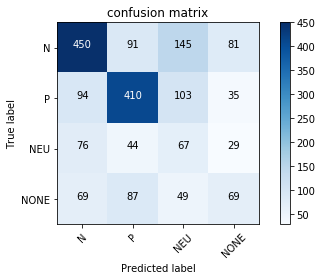

In [87]:
    
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1, layers=[em_sz*3, 50, c], drops=[0., 0.])

learn = RNN_Learner(md, TextModel(to_gpu(m)))
learn.load_encoder('lm1_enc')
learn.load('final')
predictions = np.argmax(learn.predict(), axis=1)

f1 = f1_score(tst_lbls_sampled, predictions, average='macro')
print('F1(macro) = ', f1)

acc = (tst_lbls_sampled == predictions).mean()
print('Accuracy  = ', acc)


cnf_matrix = confusion_matrix(tst_lbls_sampled, predictions)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['N', 'P', 'NEU', 'NONE'], title='confusion matrix')
plt.show()

In [131]:
def getLabel(num):
    if num == 0:
        return 'N'
    elif num == 1:
        return 'P'
    elif num == 2:
        return 'NEU'
    elif num == 3:
        return 'NONE'

In [132]:
import xml.etree.ElementTree as ET

def putTestValue(xmlFIle, out):
    tree = ET.parse(xmlFIle)
    root = tree.getroot()

    tweets = []
    file = open(out,"w") 
    print(file)
    print(len(predictions))
    for i,tweet in enumerate(root.iter('tweet')): 
        val = getLabel(predictions[list(tst_samp).index(i)])
        ID = tweet.find('tweetid').text
        #print(ID)
        file.write(ID + "\t" + val + "\n")
    file.close() 

In [133]:
DATA_PATH = Path('D:/Maestria/NLP/AdvacedSentimentAnalysis/database/')
putTestValue(DATA_PATH/"TASS/TASS2018/task1-Test.xml", TWEETSLM_PATH/"output_ulmfit_2018.txt")

<_io.TextIOWrapper name='TWEETS_LM\\2017\\output_ulmfit_2018.txt' mode='w' encoding='cp1252'>
1899


In [134]:
print(TWEETSLM_PATH/"output_ulmfit_2018.txt")

TWEETS_LM\2017\output_ulmfit_2018.txt
